In [1]:
import sys
import os
import tensorflow as tf

/Users/kirakempinska/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sys.path.append('../')

In [3]:
from settings import FIGPATH
figpath = os.path.join(FIGPATH,'figures_20000')

In [4]:
from src.data.load_data import *

In [5]:
ds = load_dataset(figpath)

In [6]:
ds

<DatasetV1Adapter shapes: (192, 192, 1), types: tf.float32>

In [25]:
import matplotlib.image as mpimg

In [26]:
image = mpimg.imread('../reports/figures/figures_20000/BR_1_city_31.png')

In [28]:
image.shape

(1050, 1050, 4)

In [29]:
import tensorflow as tf
import pathlib
import random


def preprocess_image(image):
    # image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range

    return image


def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [30]:
load_and_preprocess_image('../reports/figures/figures_20000/BR_1_city_31.png')

<tf.Tensor 'truediv:0' shape=(192, 192, 1) dtype=float32>

* Train with dataset

In [16]:
test_dataset = ds.take(100) 
train_dataset = ds.skip(100)

In [20]:
train_dataset

<DatasetV1Adapter shapes: (192, 192, 1), types: tf.float32>

In [21]:
from src.models.vae import *

import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

data = tf.placeholder(tf.float32, [None, 28, 28])

make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

# Define the model.
prior = make_prior(code_size=2)
posterior = make_encoder(data, code_size=2)
code = posterior.sample()

# Define the loss.
likelihood = make_decoder(code, [28, 28]).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)

samples = make_decoder(prior.sample(10), [28, 28]).mean()

mnist = input_data.read_data_sets('MNIST_data/')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


TypeError: float() argument must be a string or a number, not 'DatasetV1Adapter'

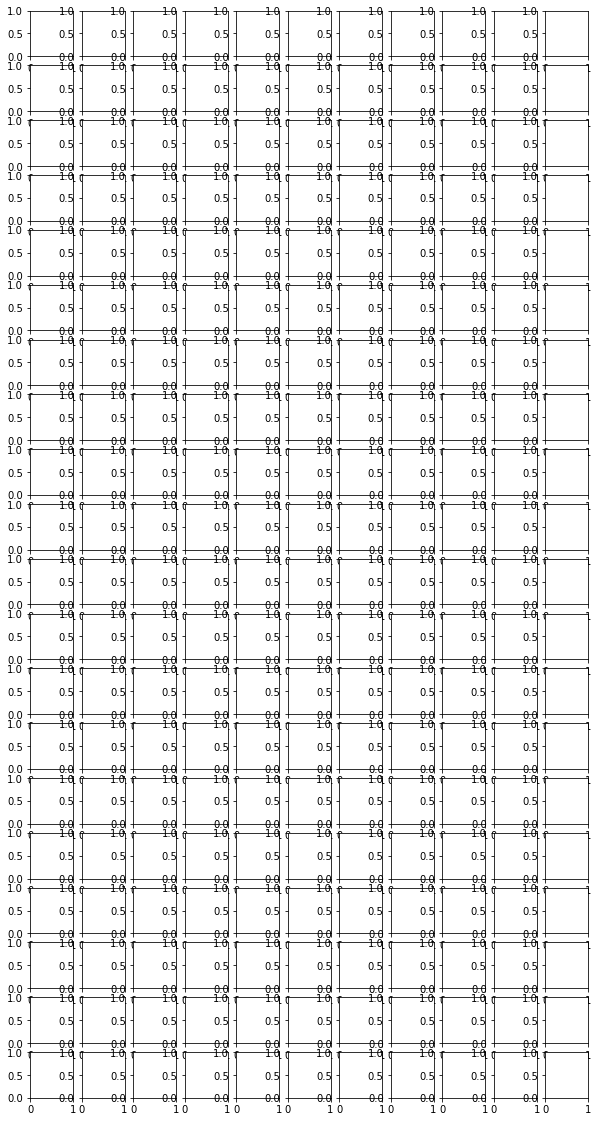

In [24]:
print(type(mnist))
fig, ax = plt.subplots(nrows=20, ncols=11, figsize=(10, 20))
with tf.train.MonitoredSession() as sess:
    for epoch in range(20):
        feed = {data: test_dataset}
        test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)
        print('Epoch', epoch, 'elbo', test_elbo)
        ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
        plot_codes(ax[epoch, 0], test_codes, mnist.test.labels)
        plot_samples(ax[epoch, 1:], test_samples)
        for _ in range(600):
            feed = {data: train_dataset.batch(100)}
            sess.run(optimize, feed)
plt.savefig('vae-mnist.png', dpi=300, transparent=True, bbox_inches='tight')

In [32]:
mnist.test.images.shape

(10000, 784)

<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch 0 elbo -543.6727


/Users/kirakempinska/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Epoch 1 elbo -172.31186
Epoch 2 elbo -165.7244
Epoch 3 elbo -160.85237
Epoch 4 elbo -156.30736
Epoch 5 elbo -153.40417
Epoch 6 elbo -151.44576
Epoch 7 elbo -149.8405
Epoch 8 elbo -148.85057
Epoch 9 elbo -147.7562
Epoch 10 elbo -147.26054
Epoch 11 elbo -146.69778
Epoch 12 elbo -146.17223
Epoch 13 elbo -145.5413
Epoch 14 elbo -145.4617


KeyboardInterrupt: 

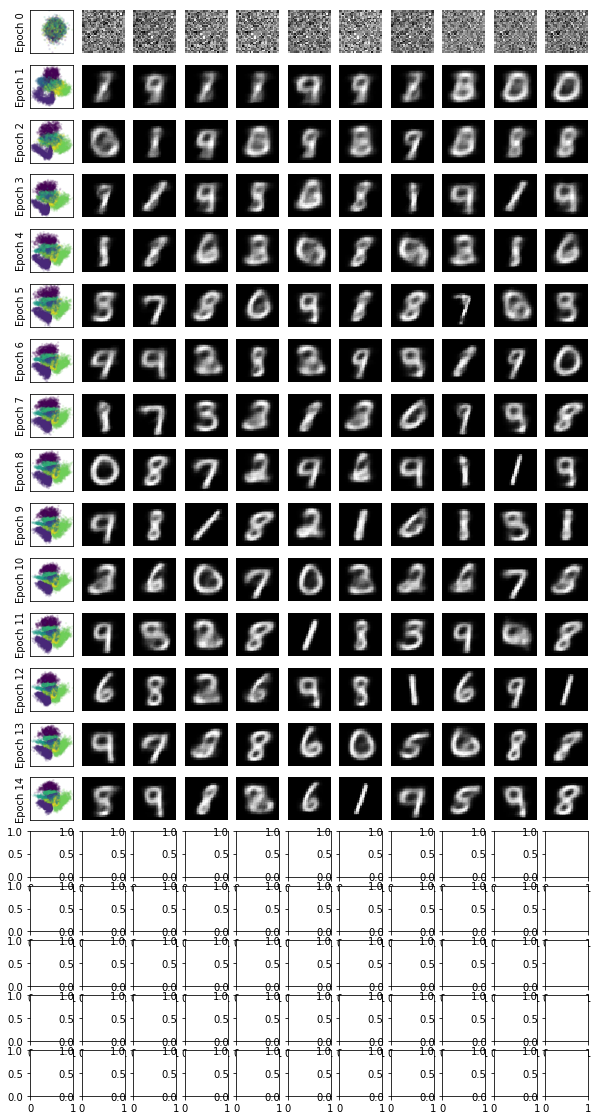

In [23]:
print(type(mnist))
fig, ax = plt.subplots(nrows=20, ncols=11, figsize=(10, 20))
with tf.train.MonitoredSession() as sess:
    for epoch in range(20):
        feed = {data: mnist.test.images.reshape([-1, 28, 28])}
        test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)
        print('Epoch', epoch, 'elbo', test_elbo)
        ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
        plot_codes(ax[epoch, 0], test_codes, mnist.test.labels)
        plot_samples(ax[epoch, 1:], test_samples)
        for _ in range(600):
            feed = {data: mnist.train.next_batch(100)[0].reshape([-1, 28, 28])}
            sess.run(optimize, feed)
plt.savefig('vae-mnist.png', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
# Wrapping all together -> Switch between train and test set using Initializable iterator
EPOCHS = 10
# create a placeholder to dynamically switch between batch sizes
batch_size = tf.placeholder(tf.int64)
x, y = tf.placeholder(tf.float32, shape=[None,2]), tf.placeholder(tf.float32, shape=[None,1])
dataset = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size).repeat()
# using two numpy arrays
train_data = (np.random.sample((100,2)), np.random.sample((100,1)))
test_data = (np.random.sample((20,2)), np.random.sample((20,1)))
iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()
# make a simple model
net = tf.layers.dense(features, 8, activation=tf.tanh) # pass the first value from iter.get_next() as input
net = tf.layers.dense(net, 8, activation=tf.tanh)
prediction = tf.layers.dense(net, 1, activation=tf.tanh)
loss = tf.losses.mean_squared_error(prediction, labels) # pass the second value from iter.get_net() as label
train_op = tf.train.AdamOptimizer().minimize(loss)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # initialise iterator with train data
    sess.run(iter.initializer, feed_dict={ x: train_data[0], y: train_data[1], batch_size: BATCH_SIZE})
    print('Training...')
    for i in range(EPOCHS):
        tot_loss = 0
        for _ in range(n_batches):
            _, loss_value = sess.run([train_op, loss])
            tot_loss += loss_value
        print("Iter: {}, Loss: {:.4f}".format(i, tot_loss / n_batches))
    # initialise iterator with test data
    sess.run(iter.initializer, feed_dict={ x: test_data[0], y: test_data[1], batch_size: test_data[0].shape[0]})
    print('Test Loss: {:4f}'.format(sess.run(loss)))

* Train VAE

In [12]:
mnist.test.images.reshape([-1, 28, 28])

NameError: name 'mnist' is not defined

In [ ]:
print(type(mnist))
fig, ax = plt.subplots(nrows=20, ncols=11, figsize=(10, 20))
with tf.train.MonitoredSession() as sess:
    for epoch in range(20):
        feed = {data: mnist.test.images.reshape([-1, 28, 28])}
        test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)
        print('Epoch', epoch, 'elbo', test_elbo)
        ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
        plot_codes(ax[epoch, 0], test_codes, mnist.test.labels)
        plot_samples(ax[epoch, 1:], test_samples)
        for _ in range(600):
            feed = {data: mnist.train.next_batch(100)[0].reshape([-1, 28, 28])}
            sess.run(optimize, feed)
plt.savefig('vae-mnist.png', dpi=300, transparent=True, bbox_inches='tight')

In [18]:
iter = ds.make_one_shot_iterator()
el = iter.get_next()

In [20]:
with tf.Session() as sess:
    print(sess.run(el).shape)

(192, 192, 3)


In [16]:
image_batch = next(iter(ds))

RuntimeError: dataset.__iter__() is only supported when eager execution is enabled.